In [1]:
# https://datawarrior.wordpress.com/2016/10/12/short-text-categorization-using-deep-neural-networks-and-word-embedding-models/

In [2]:
%matplotlib inline

In [3]:
from kaggle_quora_question_pairs_common import *

dataset.hdf
sample_submission.csv
sample_submission.csv.zip
test.csv
test.csv.zip
train.csv
train.csv.zip



/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train_df, test_df = load_train_test()
train_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
print_question_pairs(test_df[60:80])

What is life like after being imprisoned for best term?
Do you support life imprisonment for thick and pedophiles?

What are the rate common regrets in old age?
What are the most regrets that people have once they grow old?

What die good gifts for a foreign visitor to bring when they're invited to someone's home in Australia for the first time?
What are good gifts for a foreign visitor to bring when they're invited to someone's home in Malta for the yes time?

Is the USA chocolate covered strawberries have to be refrigerated?
What sex the best way to refrigerate chocolate covered strawberries?

Which oxygen the best International School In Noida Expressway?
Could friends care support be worse than LeEco India?

What are examples of fixed and variable costs in a fast food restaurant?
What is the best fast food restaurant salad?

What are the best tricks nucleus remember what you read?
What is the best way to study and remember what don't had studied?

If the United you describe the com

In [5]:
log_max_mem_usage()
train_df.shape

Current all-time max memory: 854 MB


(404290, 6)

In [6]:
# %%time
# store_data_to_hdf(train_df, test_df)

In [7]:
%%time

include_test = True
unique_questions = get_unique_questions(train_df, test_df, include_test=include_test)
char_tfidf, word_tfidf = train_char_word_tfidf(unique_questions, include_test=include_test)

log_max_mem_usage()

Current all-time max memory: 1030 MB
Current all-time max memory: 1954 MB
Current all-time max memory: 1954 MB
CPU times: user 4.51 s, sys: 260 ms, total: 4.77 s
Wall time: 4.87 s


In [8]:
def fast_pairwise_cos_sim(a, b):
    an = np.linalg.norm(a, ord=2, axis=1)
    bn = np.linalg.norm(b, ord=2, axis=1)
    ap = (a / an.reshape(a.shape[0], 1)).reshape(np.prod(a.shape))
    bp = (b / bn.reshape(b.shape[0], 1)).reshape(np.prod(b.shape))
    cp = ap * bp
    c = cp.reshape(a.shape).sum(axis=1)

    return c

In [18]:
%%time
# %time vc = transform_fasttext_word_vec(train_df.head().question1, op='mean')

def get_fasttext_features(samp, is_fast=True):
    fs_q1 = transform_fasttext_vec(samp.question1)
    fs_q2 = transform_fasttext_vec(samp.question2)

    fs_word_mean_q1 = transform_fasttext_word_vec(samp.question1, op='mean')
    fs_word_mean_q2 = transform_fasttext_word_vec(samp.question2, op='mean')

    if not is_fast:
        fs_cos = cosine_similarity(fs_q1, fs_q2).diagonal()
        fs_word_mean_cos = cosine_similarity(fs_word_mean_q1, fs_word_mean_q2).diagonal()    
        fs_cos_q1_x_word_mean_q2_cos = cosine_similarity(fs_q1, fs_word_mean_q2).diagonal()
        fs_cos_q2_x_word_mean_q1_cos = cosine_similarity(fs_word_mean_q1, fs_q2).diagonal()
    
    else:
        fs_cos = fast_pairwise_cos_sim(fs_q1, fs_q2)
        fs_word_mean_cos = fast_pairwise_cos_sim(fs_word_mean_q1, fs_word_mean_q2)
        fs_cos_q1_x_word_mean_q2_cos = fast_pairwise_cos_sim(fs_q1, fs_word_mean_q2)
        fs_cos_q2_x_word_mean_q1_cos = fast_pairwise_cos_sim(fs_word_mean_q1, fs_q2)

    return fs_cos, fs_word_mean_cos, fs_cos_q1_x_word_mean_q2_cos, fs_cos_q2_x_word_mean_q1_cos
x = get_fasttext_features(train_df.head(1000), is_fast=False)

CPU times: user 968 ms, sys: 312 ms, total: 1.28 s
Wall time: 677 ms


In [308]:
train_df.shape

(404290, 6)

In [12]:
%%time

def get_tfidf_features(samp):
    w1 = word_tfidf.transform(samp.question1)
    w2 = word_tfidf.transform(samp.question2)

    c1 = char_tfidf.transform(samp.question1)
    c2 = char_tfidf.transform(samp.question2)

    word_res = np.dot(
        w1,
        w2.T
    ).diagonal()

    char_res = np.dot(
        c1,
        c2.T
    ).diagonal()

    return word_res, char_res

x = get_tfidf_features(train_df[10000: 11000])

CPU times: user 216 ms, sys: 12 ms, total: 228 ms
Wall time: 226 ms


In [15]:
%%time
w = np.dot(f1, f2.T)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 41.7 ms


In [14]:
%%time

samp = train_df[53000:54000]
f1 = char_tfidf.transform(samp.question1)
f2 = char_tfidf.transform(samp.question2)

word_res = np.dot(
    f1,
    f2.T
).diagonal()

CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 136 ms


In [282]:
.244 * 10 #7.5

2.44

In [17]:
log_max_mem_usage()
fasttext_model = fasttext.load_model('model_full_data.bin')
log_max_mem_usage()

stops = load_stopwords()
num_pattern = re.compile('[0-9]+')
math_pattern = re.compile('\[math\](.*)\[\/math\]')

nums = '01234567890'

def transform_fasttext_vec(qs):
    return np.array(
        [fasttext_model[q.decode('utf-8')] for q in qs]
    )

def transform_fasttext_word_vec(qs, op='mean'):
    qs_vec = []
    for q in qs:
        qd = []
        q = q.decode('utf-8')
        for j in q.split():
            qd.append(fasttext_model[j])
        
        if op == 'mean':
            qs_vec.append(np.mean(qd, axis=0))
        elif op == 'sum':
            qs_vec.append(np.sum(qd, axis=0))
        else:
            raise ValueError('Unknown operation! Supported ops: [sum, mean].')
    
    return np.array(qs_vec)

def get_vector_based_features(data_df, local_batch=1000):
    # data_df size should be about 40000 when used in parallel to observe effects of optimization.
    i = 0

    word_dataset = np.array([])
    char_dataset = np.array([])

    fs_cos_dataset = np.array([])
    fs_word_mean_cos_dataset = np.array([])
    fs_cos_q1_x_word_mean_q2_cos_dataset = np.array([])
    fs_cos_q2_x_word_mean_q1_cos_dataset = np.array([])

    while True:
        samp = data_df[i * local_batch: (i + 1) * local_batch]
        i += 1

        if samp.empty:
            break
            
        word_res, char_res = get_tfidf_features(samp)
        (
            fs_cos, fs_word_mean_cos,
            fs_cos_q1_x_word_mean_q2_cos, fs_cos_q2_x_word_mean_q1_cos
        ) = get_fasttext_features(samp)

        word_dataset = np.concatenate([word_dataset, word_res])
        char_dataset = np.concatenate([char_dataset, char_res])

        fs_cos_dataset = np.concatenate([fs_cos_dataset, fs_cos])
        fs_word_mean_cos_dataset = np.concatenate([fs_word_mean_cos_dataset, fs_word_mean_cos])
        fs_cos_q1_x_word_mean_q2_cos_dataset = np.concatenate(
            [fs_cos_q1_x_word_mean_q2_cos_dataset, fs_cos_q1_x_word_mean_q2_cos]
        )
        fs_cos_q2_x_word_mean_q1_cos_dataset = np.concatenate(
            [fs_cos_q2_x_word_mean_q1_cos_dataset, fs_cos_q2_x_word_mean_q1_cos]
        )

    return pd.DataFrame(
        dict(
            wv=word_dataset, 
            cv=char_dataset,
            fs_cos=fs_cos_dataset,
            fs_word_mean_cos=fs_word_mean_cos_dataset,
            fs_cos_q1_x_word_mean_q2_cos=fs_cos_q1_x_word_mean_q2_cos_dataset,
            fs_cos_q2_x_word_mean_q1_cos=fs_cos_q2_x_word_mean_q1_cos_dataset,
        ), index=data_df.index
    )

def get_heuristic_scores(q1, q2, ns_q1, ns_q2, swap):
#     n_q1 = {}
#     n_q2 = {}

#     for n in nums:
#         qc1 = q1.count(n)
#         qc2 = q2.count(n)
#         n_q1['q1_{}'.format(n)] = qc1
#         n_q2['q2_{}'.format(n)] = qc2

    if swap:
        q1 = ns_q1
        q2 = ns_q2

    exact_nums_q1 = num_pattern.findall(q1)
    exact_nums_q2 = num_pattern.findall(q2)
    
    math_q1 = math_pattern.findall(q1)
    math_q2 = math_pattern.findall(q2)

    num_exact_nums_match = len([n1 for n1 in exact_nums_q1 if n1 in exact_nums_q2])
    math_pattern_match = len([n1 for n1 in math_q1 if n1 in math_q2])
    
    is_q1_math = 1 * any(math_q1)
    is_q2_math = 1 * any(math_q2)
    is_both_math = is_q1_math * is_q2_math

#     qq2 = pd.Series(Counter([s for s in q1 if s.isupper()]))
#     qq1 = pd.Series(Counter([s for s in q2 if s.isupper()]))
    
#     sim_caps_rate = (qq1/qq2).mean()
#     num_caps_q1 = qq1.sum() 
#     num_caps_q2 = qq2.sum()

#     mean_caps_q1 = qq1.mean() 
#     mean_caps_q2 = qq2.mean()
    
    num_terms_q1 = len(q1.split())
    num_terms_q2 = len(q2.split())
    
    len_q1 = len(q1)
    len_q2 = len(q2)

    res = dict(
        num_exact_nums_match=num_exact_nums_match,
        math_pattern_match=math_pattern_match,
        is_q1_math=is_q1_math,
        is_q2_math=is_q2_math,
        is_both_math=is_both_math,
        length_diff=abs(len_q1 - len_q2),
        len_q1=len_q1,
        len_q2=len_q2,
        word_num_diff=abs(num_terms_q1 - num_terms_q2),
        num_terms_q1=num_terms_q1,
        num_terms_q2=num_terms_q2,
#         sim_caps_rate=sim_caps_rate,
#         mean_caps_q1=mean_caps_q1,
#         mean_caps_q2=mean_caps_q2,
#         num_caps_q1=num_caps_q1,
#         num_caps_q2=num_caps_q2,
    )
    
    # res.update(n_q1)
    # res.update(n_q2)
    
    return res


heuristics_feature_names = [
    'num_exact_nums_match',
    'math_pattern_match',
    'is_q1_math',
    'is_q2_math',
    'is_both_math',
    'length_diff',
    'len_q1',
    'len_q2',
    'word_num_diff',
    'num_terms_q1',
    'num_terms_q2',
]


def score_row(row, check_stops=False, swap=False):
    ix, row = row

    q1 = row.question1
    q2 = row.question2
    
    ns_q1 = [i for i in q1.lower().split() if i not in stops]
    ns_q2 = [i for i in q1.lower().split() if i not in stops]

    if not all([ns_q1, ns_q2]) and check_stops:
        if ix % 5 == 0:
            # 39405
            print('here! {}'.format(ix))

        return {i: np.nan for i in heuristics_feature_names}
    
    ns_q1 = ' '.join(ns_q1)
    ns_q2 = ' '.join(ns_q2)

    return get_heuristic_scores(q1, q2, ns_q1, ns_q2, swap=swap)

Current all-time max memory: 1954 MB
Current all-time max memory: 4916 MB


In [16]:
ix =  203
row = train_df.ix[ix]
q1 = row.question1
q2 = row.question2
print q1
print q2
print set(q1.lower().split()).difference(stops)
print set(q2.lower().split()).difference(stops)
print row.is_duplicate
print score_row((ix, row))

Why do people hate Hillary Clinton?
What are the reasons that people dislike Hillary Clinton?
set(['hillary', 'hate', 'clinton?', 'people'])
set(['reasons', 'hillary', 'dislike', 'clinton?', 'people'])
1
{'is_q2_math': 0, 'math_pattern_match': 0, 'is_q1_math': 0, 'length_diff': 22, 'num_terms_q1': 6, 'num_terms_q2': 9, 'is_both_math': 0, 'num_exact_nums_match': 0, 'word_num_diff': 3, 'len_q1': 35, 'len_q2': 57}


In [58]:
# %%time
# ds = []
# # samp = train_df[404000:]
# samp = train_df.head(200000)  # [30000:50000]
# for row in samp.iterrows():
#     ds.append(score_row(row))

# ds = pd.DataFrame(ds, index=samp.index)
# #ds

In [19]:
# %%time
def score_heuristic_batch(samp_index, is_train):
    dataset_store = pd.HDFStore('../input/dataset.hdf', mode='r')
    if is_train:
        samp = dataset_store.select('train_df', where=samp_index)
    else:
        samp = dataset_store.select('test_df', where=samp_index)
    dataset_store.close()

    heuristics_scores = []

    for row in samp.iterrows():
#         if row[0] and row[0] % 10000 == 0:
#             print(row[0])

        heuristics_scores.append(score_row(row))

    heuristics_scores = pd.DataFrame(heuristics_scores, index=samp.index)

    return heuristics_scores


def heuristic_score_parallel_interface(t_df, is_train):
    return delayed(score_heuristic_batch)(t_df.index, is_train)


def vector_based_score_parallel_interface(t_df, is_train):
    return delayed(get_vector_based_features)(t_df)


def parallel_scorer(samp, scorer_interface, is_train, batch, num_proc):
    # Consumes 1.5G for batch=1000 and num_proc=4 for tfidf interface
    # Use vector_based_features::batch=10000, heuristic_features::batch=20000
    # scorer_interface::[heuristic_score_parallel_interface, vector_based_score_parallel_interface]
    # Adjust batch depending on the interface used since the memory is dependent on the batch used.

    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(scorer_interface(t_df, is_train))
            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


def parallel_get_heuristic_scores(samp, is_train, batch=10000, num_proc=4):
    return parallel_scorer(samp, heuristic_score_parallel_interface, is_train, batch, num_proc)


def parallel_get_vector_based_scores(samp, is_train, batch=40000, num_proc=4):
    # The batch size for the size of the dataset should be large to maximize effect of parallelization.
    # The batch here is different from the batch used in the method `get_vector_based_features`
    return parallel_scorer(samp, vector_based_score_parallel_interface, is_train, batch, num_proc)


NUM_PROC = max(1, mp.cpu_count() - 1)

def parallel_get_features(samp, is_train, tfidf_sample_batch=8000, heuristics_sample_batch=10000):
    start_time = time.time()

    vector_based_features = parallel_get_vector_based_scores(samp, is_train, batch=tfidf_sample_batch, num_proc=NUM_PROC)
    print('Finished computing tfidf features after {} seconds.'.format((time.time() - start_time)))

    heuristics_scores = parallel_get_heuristic_scores(samp, is_train, batch=heuristics_sample_batch, num_proc=NUM_PROC)
    print('Finished computing heuristic features after {} seconds.'.format((time.time() - start_time)))

    features = pd.concat([vector_based_features, heuristics_scores], axis=1)
    return features


def get_features(samp):
    start_time = time.time()
    
    vector_based_features = get_vector_based_features(samp)
    print('Finished computing tfidf features after {} seconds.'.format((time.time() - start_time)))

    heuristics_scores = []

    for row in samp.iterrows():
        if row[0] and row[0] % 10000 == 0:
            print(row[0])
  
        heuristics_scores.append(score_row(row))

    heuristics_scores = pd.DataFrame(heuristics_scores, index=samp.index)
    
    features = pd.concat([vector_based_features, heuristics_scores], axis=1)
    
    return features


# samp = train_df

# X_train = get_features(samp)
# y_train = samp.is_duplicate

# log_max_mem_usage()

In [20]:
GB = 1000000000.0  # Not really GB :D
SAVE_GB = 1.5 * GB

def get_tfidf_batch_size(df, NUM_PROC):
    # Memory (4.2 - 2.01 = 2.19G) used with 7 processes and 404290 rows (train) with batch size 57755

    mem_per_row = 2.19 / 57755 / 7
    available_mem = (psutil.virtual_memory().available - SAVE_GB) / GB
    tfidf_batch_size = df.shape[0] / NUM_PROC
    delta = 10000

    if (df.shape[0] * mem_per_row) > available_mem:
        while (tfidf_batch_size * NUM_PROC * mem_per_row) > available_mem:
            tfidf_batch_size -= delta

    return tfidf_batch_size

NUM_PROC=7
train_tfidf_batch_size = get_tfidf_batch_size(train_df, NUM_PROC=NUM_PROC)
train_tfidf_batch_size

57755

In [65]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = 34285
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

34285
Current batch in main thread: 205710
Current batch in main thread: 445705
CPU times: user 776 ms, sys: 292 ms, total: 1.07 s
Wall time: 2min 10s


In [321]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = 34285
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

34285
Current batch in main thread: 205710
Current batch in main thread: 445705
CPU times: user 860 ms, sys: 672 ms, total: 1.53 s
Wall time: 1min 40s


In [315]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = int(34285./ 2)
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

17142
Current batch in main thread: 102852
Current batch in main thread: 222846
Current batch in main thread: 342840
CPU times: user 884 ms, sys: 592 ms, total: 1.48 s
Wall time: 1min 28s


In [316]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = int(34285./ 3)
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

11428
Current batch in main thread: 68568
Current batch in main thread: 148564
Current batch in main thread: 228560
Current batch in main thread: 308556
CPU times: user 848 ms, sys: 620 ms, total: 1.47 s
Wall time: 1min 33s


In [319]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = int(34285./ 4)
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

8571
Current batch in main thread: 51426
Current batch in main thread: 111423
Current batch in main thread: 171420
Current batch in main thread: 231417
Current batch in main thread: 291414
CPU times: user 940 ms, sys: 576 ms, total: 1.52 s
Wall time: 1min 35s


In [320]:
%%time
n = 240000
train_tfidf_batch_size = get_tfidf_batch_size(train_df.head(n), NUM_PROC=NUM_PROC)
train_tfidf_batch_size = 8000
print train_tfidf_batch_size
tc = train_df.head(n).copy()
dtfidf_fs = parallel_get_vector_based_scores(tc, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

8000
Current batch in main thread: 48000
Current batch in main thread: 104000
Current batch in main thread: 160000
Current batch in main thread: 216000
Current batch in main thread: 272000
CPU times: user 984 ms, sys: 652 ms, total: 1.64 s
Wall time: 1min 43s


In [314]:
34285 * 7

239995

In [66]:
dtfidf_fs.corr()

,cv,fs_cos,fs_cos_q1_x_word_mean_q2_cos,fs_cos_q2_x_word_mean_q1_cos,fs_word_mean_cos,wv
cv,1.000000,0.792513,0.625655,0.614079,0.827256,0.820395
fs_cos,0.792513,1.000000,0.772933,0.765076,0.841396,0.652260
fs_cos_q1_x_word_mean_q2_cos,0.625655,0.772933,1.000000,0.859420,0.718674,0.494979
fs_cos_q2_x_word_mean_q1_cos,0.614079,0.765076,0.859420,1.000000,0.711404,0.487347
fs_word_mean_cos,0.827256,0.841396,0.718674,0.711404,1.000000,0.714009
wv,0.820395,0.652260,0.494979,0.487347,0.714009,1.000000


In [322]:
dtfidf_fs.corr()

,cv,fs_cos,fs_cos_q1_x_word_mean_q2_cos,fs_cos_q2_x_word_mean_q1_cos,fs_word_mean_cos,wv
cv,1.000000,0.792513,0.625655,0.614079,0.827256,0.820395
fs_cos,0.792513,1.000000,0.772933,0.765076,0.841396,0.652260
fs_cos_q1_x_word_mean_q2_cos,0.625655,0.772933,1.000000,0.859420,0.718674,0.494979
fs_cos_q2_x_word_mean_q1_cos,0.614079,0.765076,0.859420,1.000000,0.711404,0.487347
fs_word_mean_cos,0.827256,0.841396,0.718674,0.711404,1.000000,0.714009
wv,0.820395,0.652260,0.494979,0.487347,0.714009,1.000000


In [106]:
%%time
dheur = parallel_get_heuristic_scores(train_df, is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

Current batch in main thread: 346530
Current batch in main thread: 750815
CPU times: user 132 ms, sys: 200 ms, total: 332 ms
Wall time: 12.7 s


In [88]:
# heuristics_scores = []
# samp = train_df[404285: 404293]
# for row in samp.iterrows():
#     if row[0] and row[0] % 10000 == 0:
#         print(row[0])

#     heuristics_scores.append(score_row(row))
# heuristics_scores

In [43]:
ix = 410000
batch = 30000
samp = test_df[ix: ix + batch]
print(samp.index)
dataset_store = pd.HDFStore('../input/dataset.hdf', mode='r')
# sp = dataset_store.select('train_df', where=samp.index)
sp = dataset_store.select('test_df', where=samp.index)
dataset_store.close()
# sp

RangeIndex(start=410000, stop=440000, step=1)


In [21]:
%%time
train_batch_size = get_tfidf_batch_size(train_df, NUM_PROC=NUM_PROC)

X_train = parallel_get_features(
    train_df, is_train=True, tfidf_sample_batch=train_batch_size, heuristics_sample_batch=train_batch_size
)
y_train = train_df.is_duplicate

log_max_mem_usage()

Current batch in main thread: 346530
Current batch in main thread: 750815
Finished computing tfidf features after 80.1887078285 seconds.
Current batch in main thread: 346530
Current batch in main thread: 750815
Finished computing heuristic features after 88.9727699757 seconds.
Current all-time max memory: 5069 MB
CPU times: user 852 ms, sys: 280 ms, total: 1.13 s
Wall time: 1min 28s


In [74]:
pd.concat([X_train, y_train], axis=1).to_hdf('kaggle-quora', 'features_dataset_{}'.format('_'.join(X_train.columns)))

In [22]:
X_train.columns

Index([u'cv', u'fs_cos', u'fs_cos_q1_x_word_mean_q2_cos',
       u'fs_cos_q2_x_word_mean_q1_cos', u'fs_word_mean_cos', u'wv',
       u'is_both_math', u'is_q1_math', u'is_q2_math', u'len_q1', u'len_q2',
       u'length_diff', u'math_pattern_match', u'num_exact_nums_match',
       u'num_terms_q1', u'num_terms_q2', u'word_num_diff'],
      dtype='object')

In [30]:
# %%time
# X_train = get_features(samp)
# y_train = samp.is_duplicate

# log_max_mem_usage()

In [23]:
%%time
xx_train, xx_valid, yy_train, yy_valid = resample_and_split_train_val_data(
    pd.concat([X_train, y_train], axis=1), p=0.17426, test_size=0.2
)

CPU times: user 1.61 s, sys: 56 ms, total: 1.67 s
Wall time: 1.67 s


In [24]:
log_max_mem_usage()

Current all-time max memory: 5480 MB


In [34]:
mnmx_scaler = MinMaxScaler()
mnmx_scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [90]:
%%time
bst = train_xgb(mnmx_scaler.transform(xx_train), mnmx_scaler.transform(xx_valid), yy_train, yy_valid)

[0]	train-logloss:0.681488	valid-logloss:0.681474
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.586271	valid-logloss:0.586133
[20]	train-logloss:0.519147	valid-logloss:0.518938
[30]	train-logloss:0.470288	valid-logloss:0.470042
[40]	train-logloss:0.434024	valid-logloss:0.433764
[50]	train-logloss:0.406559	valid-logloss:0.406323
[60]	train-logloss:0.385529	valid-logloss:0.385331
[70]	train-logloss:0.36932	valid-logloss:0.369186
[80]	train-logloss:0.356793	valid-logloss:0.356724
[90]	train-logloss:0.347	valid-logloss:0.347017
[100]	train-logloss:0.339216	valid-logloss:0.339313
[110]	train-logloss:0.333044	valid-logloss:0.333217
[120]	train-logloss:0.32814	valid-logloss:0.328399
[130]	train-logloss:0.324207	valid-logloss:0.324541
[140]	train-logloss:0.321065	valid-logloss:0.321467
[150]	train-logloss:0.318524	valid-logloss:0.318991
[160]	train-logloss:0.316457	val

In [36]:
%%time
bst = train_xgb(mnmx_scaler.transform(xx_train), mnmx_scaler.transform(xx_valid), yy_train, yy_valid, num_boost_round=1000, max_depth=10)

[0]	train-logloss:0.681424	valid-logloss:0.681481
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.58567	valid-logloss:0.586282
[20]	train-logloss:0.517953	valid-logloss:0.519099
[30]	train-logloss:0.468482	valid-logloss:0.470141
[40]	train-logloss:0.431478	valid-logloss:0.43365
[50]	train-logloss:0.403158	valid-logloss:0.405872
[60]	train-logloss:0.381429	valid-logloss:0.384648
[70]	train-logloss:0.364461	valid-logloss:0.368191
[80]	train-logloss:0.351133	valid-logloss:0.35538
[90]	train-logloss:0.340515	valid-logloss:0.345272
[100]	train-logloss:0.33196	valid-logloss:0.337261
[110]	train-logloss:0.325068	valid-logloss:0.330914
[120]	train-logloss:0.319578	valid-logloss:0.325893
[130]	train-logloss:0.315186	valid-logloss:0.32194
[140]	train-logloss:0.311551	valid-logloss:0.31872
[150]	train-logloss:0.308514	valid-logloss:0.316105
[160]	train-logloss:0.305892	vali

In [27]:
bst.save_model('xgb_model_with_fasttext_features_standard_scaler.model')

In [37]:
for ix, col in enumerate(xx_train.columns):
    print ix, col

0 cv
1 fs_cos
2 fs_cos_q1_x_word_mean_q2_cos
3 fs_cos_q2_x_word_mean_q1_cos
4 fs_word_mean_cos
5 is_both_math
6 is_q1_math
7 is_q2_math
8 len_q1
9 len_q2
10 length_diff
11 math_pattern_match
12 num_exact_nums_match
13 num_terms_q1
14 num_terms_q2
15 word_num_diff
16 wv


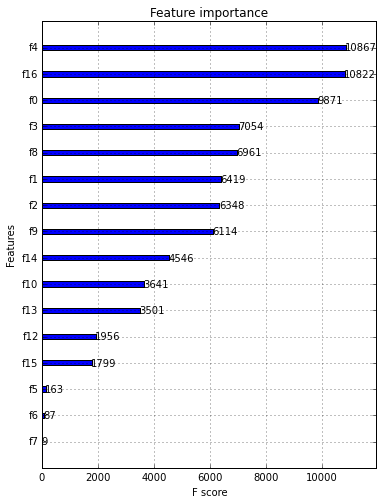

In [93]:
plt.rcParams['figure.figsize'] = (6.0, 8.0)
xgb.plot_importance(bst)
plt.show()

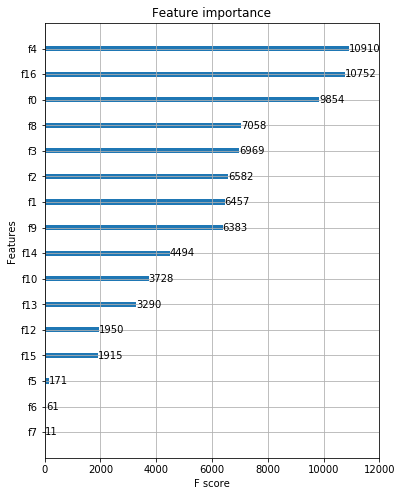

In [29]:
plt.rcParams['figure.figsize'] = (6.0, 8.0)
xgb.plot_importance(bst)
plt.show()

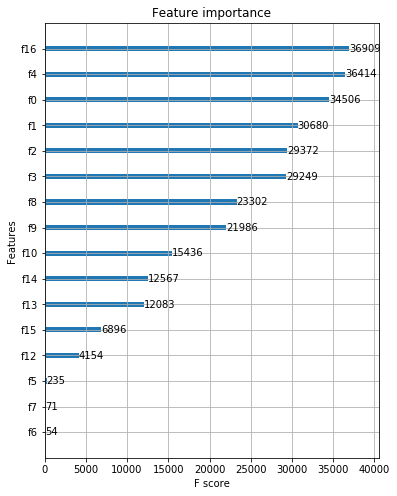

In [38]:
plt.rcParams['figure.figsize'] = (6.0, 8.0)
xgb.plot_importance(bst)
plt.show()

In [ ]:
# 0 cv
# 1 fs_cos
# 2 fs_cos_q1_x_word_mean_q2_cos
# 3 fs_cos_q2_x_word_mean_q1_cos
# 4 fs_word_mean_cos
# 5 is_both_math
# 6 is_q1_math
# 7 is_q2_math
# 8 len_q1
# 9 len_q2
# 10 length_diff
# 11 math_pattern_match
# 12 num_exact_nums_match
# 13 num_terms_q1
# 14 num_terms_q2
# 15 word_num_diff
# 16 wv

In [99]:
%%time
test_batch_size = get_tfidf_batch_size(test_df, NUM_PROC=NUM_PROC)
print('Test batch size: {}'.format(test_batch_size))

X_test = parallel_get_features(
    test_df, is_train=False, tfidf_sample_batch=test_batch_size, heuristics_sample_batch=test_batch_size
)

log_max_mem_usage()

Test batch size: 165113
Current batch in main thread: 990678
Current batch in main thread: 2146469
Current batch in main thread: 3302260
Finished computing tfidf features after 1447.32466602 seconds.
Current batch in main thread: 990678
Current batch in main thread: 2146469
Current batch in main thread: 3302260
Finished computing heuristic features after 1558.31889009 seconds.
Current all-time max memory: 12826 MB
CPU times: user 7.75 s, sys: 2.29 s, total: 10 s
Wall time: 25min 58s


In [30]:
%%time
test_batch_size = get_tfidf_batch_size(test_df, NUM_PROC=NUM_PROC)
print('Test batch size: {}'.format(test_batch_size))

X_test = parallel_get_features(
    test_df, is_train=False, tfidf_sample_batch=test_batch_size, heuristics_sample_batch=test_batch_size
)

log_max_mem_usage()

Test batch size: 335113
Current batch in main thread: 2010678
Current batch in main thread: 4356469
Finished computing tfidf features after 463.055599928 seconds.
Current batch in main thread: 2010678
Current batch in main thread: 4356469
Finished computing heuristic features after 513.302219868 seconds.
Current all-time max memory: 6387 MB
CPU times: user 4.58 s, sys: 820 ms, total: 5.4 s
Wall time: 8min 33s


In [100]:
%%time
X_test.to_hdf('kaggle-quora', 'test-features-X_test-fasttext')

/home/avsolatorio/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'test-features-X_test-fasttext'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


CPU times: user 116 ms, sys: 176 ms, total: 292 ms
Wall time: 314 ms


In [39]:
%%time
d_test = xgb.DMatrix(mnmx_scaler.transform(X_test[xx_train.columns]))
y_pred = bst.predict(d_test)

CPU times: user 3min 57s, sys: 132 ms, total: 3min 57s
Wall time: 30.2 s


,cv,fs_cos,fs_cos_q1_x_word_mean_q2_cos,fs_cos_q2_x_word_mean_q1_cos,fs_word_mean_cos,wv,is_both_math,is_q1_math,is_q2_math,len_q1,len_q2,length_diff,math_pattern_match,num_exact_nums_match,num_terms_q1,num_terms_q2,word_num_diff
0,0.264866,0.817675,0.667519,0.633732,0.765498,0.142376,0,0,0,57,68,11,0,1,11,14,3
1,0.479405,0.866874,0.685217,0.673787,0.786820,0.268047,0,0,0,66,43,23,0,0,14,7,7
2,0.497612,0.847755,0.590761,0.615242,0.839712,0.295772,0,0,0,60,29,31,0,0,14,6,8
3,0.157735,0.566624,0.476788,0.573481,0.583666,0.000000,0,0,0,27,17,10,0,0,4,3,1
4,0.337109,0.727845,0.572419,0.635509,0.844452,0.279861,0,0,0,32,30,2,0,0,4,6,2


In [40]:
sub = pd.DataFrame()

sub['test_id'] = test_df['test_id']
sub['is_duplicate'] = y_pred

sub.to_csv('xgb_submission_with_fasttext_features_minmax_scaler_depth10{}.csv'.format(datetime.now()), index=False)

In [41]:
sub.mean() 

test_id         1.173124e+06
is_duplicate    1.206339e-01
dtype: float32

In [33]:
sub.mean() 

test_id         1.173124e+06
is_duplicate    1.161454e-01
dtype: float32

In [172]:
%%time
bst_noscale = train_xgb(X_train, None, y_train, None, num_boost_round=10000, max_depth=10)

[0]	train-logloss:0.68608
Will train until train-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.628039
[20]	train-logloss:0.586361
[30]	train-logloss:0.555488
[40]	train-logloss:0.531921
[50]	train-logloss:0.513619
[60]	train-logloss:0.499051
[70]	train-logloss:0.48739
[80]	train-logloss:0.477985
[90]	train-logloss:0.470449
[100]	train-logloss:0.464213
[110]	train-logloss:0.459012
[120]	train-logloss:0.454582
[130]	train-logloss:0.450912
[140]	train-logloss:0.447906
[150]	train-logloss:0.445341
[160]	train-logloss:0.443138
[170]	train-logloss:0.441461
[180]	train-logloss:0.440003
[190]	train-logloss:0.438608
[200]	train-logloss:0.4373
[210]	train-logloss:0.436248
[220]	train-logloss:0.435209
[230]	train-logloss:0.434281
[240]	train-logloss:0.433522
[250]	train-logloss:0.432775
[260]	train-logloss:0.432185
[270]	train-logloss:0.431522
[280]	train-logloss:0.430799
[290]	train-logloss:0.430172
[300]	train-logloss:0.429518
[310]	train-logloss:0.428816
[320]	train-logloss:0.428

In [173]:
%%time
d_test = xgb.DMatrix(X_test[X_train.columns])
y_pred = bst_noscale.predict(d_test)

sub_noscale = pd.DataFrame()

sub_noscale['test_id'] = test_df['test_id']
sub_noscale['is_duplicate'] = y_pred

sub_noscale.to_csv('xgb_noscale_submission_with_fasttext_features_{}.csv'.format(datetime.now()), index=False)

CPU times: user 3h 5min 30s, sys: 1.41 s, total: 3h 5min 31s
Wall time: 23min 19s


In [174]:
sub_noscale.mean()

test_id         1.173124e+06
is_duplicate    2.290520e-01
dtype: float32

In [170]:
print_question_pairs(test_df.head(10), sample=False)

How does the Surface Pro himself 4 compare with iPad Pro?
Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?

Should I have a hair transplant at age 24? How much would it cost?
How much cost does hair transplant require?

What but is the best way to send money from China to the US?
What you send money to China?

Which food not emulsifiers?
What foods fibre?

How "aberystwyth" start reading?
How their can I start reading?

How are the two wheeler insurance from Bharti Axa insurance?
I admire I am considering of buying insurance from them

How can I reduce my belly fat through a diet?
How can I reduce my lower belly fat in one month?

By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against issue black money?
How will the recent move to declare 500 and 1000 denomination lewin illegal will curb black money?

What are the how best books of all time?
What are some of the military history books of all time?

After 12th years old boy and I had sex with

In [128]:
sub.mean()

test_id         1.173124e+06
is_duplicate    3.091868e-01
dtype: float32

In [126]:
print_question_pairs(test_df.head(10), sample=False)

How does the Surface Pro himself 4 compare with iPad Pro?
Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?

Should I have a hair transplant at age 24? How much would it cost?
How much cost does hair transplant require?

What but is the best way to send money from China to the US?
What you send money to China?

Which food not emulsifiers?
What foods fibre?

How "aberystwyth" start reading?
How their can I start reading?

How are the two wheeler insurance from Bharti Axa insurance?
I admire I am considering of buying insurance from them

How can I reduce my belly fat through a diet?
How can I reduce my lower belly fat in one month?

By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against issue black money?
How will the recent move to declare 500 and 1000 denomination lewin illegal will curb black money?

What are the how best books of all time?
What are some of the military history books of all time?

After 12th years old boy and I had sex with

In [147]:
%%time
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1632


bst_noscale_new_params = train_xgb(xx_train, xx_valid, yy_train, yy_valid, num_boost_round=1000, params=params)
d_test = xgb.DMatrix(X_test[xx_train.columns])
y_pred = bst_noscale_new_params.predict(d_test)

sub_noscale_new_params = pd.DataFrame()

sub_noscale_new_params['test_id'] = test_df['test_id']
sub_noscale_new_params['is_duplicate'] = y_pred

sub_noscale_new_params.to_csv('xgb_noscale_new_params_submission_with_fasttext_features_{}.csv'.format(datetime.now()), index=False)

[0]	train-logloss:0.681833	valid-logloss:0.681812
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.589696	valid-logloss:0.589467
[20]	train-logloss:0.524702	valid-logloss:0.524303
[30]	train-logloss:0.477756	valid-logloss:0.477221
[40]	train-logloss:0.442764	valid-logloss:0.442127
[50]	train-logloss:0.416558	valid-logloss:0.415839
[60]	train-logloss:0.396565	valid-logloss:0.395776
[70]	train-logloss:0.381103	valid-logloss:0.38028
[80]	train-logloss:0.369347	valid-logloss:0.36849
[90]	train-logloss:0.359886	valid-logloss:0.358994
[100]	train-logloss:0.352563	valid-logloss:0.351654
[110]	train-logloss:0.346779	valid-logloss:0.345861
[120]	train-logloss:0.342123	valid-logloss:0.341209
[130]	train-logloss:0.338357	valid-logloss:0.337436
[140]	train-logloss:0.335277	valid-logloss:0.334367
[150]	train-logloss:0.332846	valid-logloss:0.331949
[160]	train-logloss:0.330918	

In [149]:
print(log_loss(y_train, bst_noscale_new_params.predict(xgb.DMatrix(X_train[xx_train.columns]))))

0.580489117718


In [150]:
sub_noscale_new_params.mean()

test_id         1.173124e+06
is_duplicate    1.076574e-01
dtype: float32

In [ ]:
0.1076574

In [130]:
lm_model = LogisticRegression()
lm_model.fit(xx_train, yy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [131]:
cross_val_score(lm_model, xx_train, yy_train, scoring=log_loss_scorer)

array([ 0.33982343,  0.33920535,  0.34006824])

In [133]:
# %%time
lm_sub = pd.DataFrame()

lm_sub['test_id'] = test_df['test_id']
lm_sub['is_duplicate'] = lm_model.predict_proba(X_test)[:, 1]

# lm_sub.to_csv('lm_submission_{}.csv'.format(datetime.now()), index=False)
lm_sub.head()

,test_id,is_duplicate
0,0,3.933571e-04
1,1,2.023411e-07
2,2,4.521903e-08
3,3,3.950088e-03
4,4,5.527670e-03


In [137]:
lm_sub.mean()

test_id         1.172898e+06
is_duplicate    5.204300e-02
dtype: float64

In [158]:
llm_sub.mean()

test_id         1.172898e+06
is_duplicate    9.189859e-02
dtype: float64

In [159]:
rrf_sub = pd.read_csv('rf_submission_2017-03-23 02:15:44.718465.csv')

In [160]:
rrf_sub.mean()

test_id         1.172898e+06
is_duplicate    1.633452e-01
dtype: float64

In [141]:
sub_noscale.mean()

test_id         1.173124e+06
is_duplicate    1.097158e-01
dtype: float32

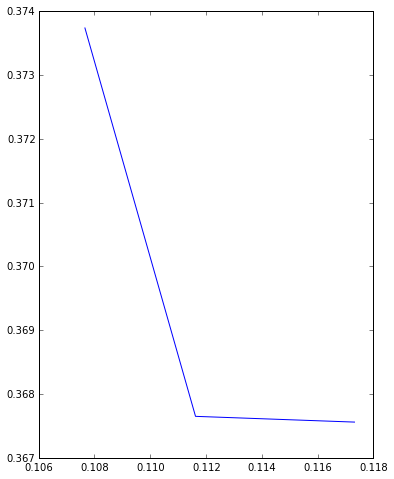

In [157]:
internal_score, pb_score = zip(*sorted([(0.1076574, 0.37374), (0.117319, 0.36756), (0.1116215, 0.36765)]))
plt.plot(internal_score, pb_score)

In [132]:
scaler = StandardScaler()

char_lm_model = LogisticRegression(C=100)
word_lm_model = LogisticRegression(C=1)
length_diff_lm_model = LogisticRegression(C=1)
word_num_diff_lm_model = LogisticRegression(C=1)

rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, min_samples_split=3, n_jobs=NUM_PROC)
lm_model = LogisticRegression()

def log_loss_scorer(model, X, y):
    return log_loss(y, model.predict_proba(X))

def fit_models(X, y):
    rf_model.fit(X_train, y_train)
    char_lm_model.fit(X_train.cv.values.reshape(-1, 1), y_train)
    word_lm_model.fit(X_train.wv.values.reshape(-1, 1), y_train)
    length_diff_lm_model.fit(X_train.length_diff.values.reshape(-1, 1), y_train)
    word_num_diff_lm_model.fit(X_train.word_num_diff.values.reshape(-1, 1), y_train)

def predict(X):
#     weights = dict(zip(X.columns, rf_model.feature_importances_))
    char_pred = char_lm_model.predict_proba(X.cv.values.reshape(-1, 1))[:, 1] # * weights['cv']
    word_pred = word_lm_model.predict_proba(X.wv.values.reshape(-1, 1))[:, 1] # * weights['wv']
    length_diff_pred = length_diff_lm_model.predict_proba(X.length_diff.values.reshape(-1, 1))[:, 1] # * weights['length_diff']
    word_num_diff_pred = word_num_diff_lm_model.predict_proba(X.word_num_diff.values.reshape(-1, 1))[:, 1] # * weights['word_num_diff']
    rf_pred = rf_model.predict_proba(X)[:, 1]

    return [char_pred, word_pred, length_diff_pred, word_num_diff_pred, rf_pred]

In [133]:
%%time

lm_model.fit(os_X_train, os_y_train)

print(log_loss_scorer(lm_model, X_valid, y_valid))

0.344890944025


In [134]:
%%time

rf_model.fit(os_X_train, os_y_train)

print(log_loss_scorer(rf_model, X_valid, y_valid))

0.211987538739


In [136]:
%%time
# fit_models(X_train, y_train)
cvs = cross_val_score(rf_model, os_X_train, os_y_train, scoring=log_loss_scorer)
print(cvs)

[ 0.24221531  0.24187433  0.24231307]
CPU times: user 11min 7s, sys: 1.11 s, total: 11min 9s
Wall time: 1min 40s


In [139]:
print(roc_auc_score(os_y_train, rf_model.predict_proba(os_X_train)[:, 1]))
print(roc_auc_score(y_valid, rf_model.predict_proba(X_valid)[:, 1]))

0.999755690807
0.954475840628


In [162]:
# %%time
rf_val = pd.DataFrame()
val_id = X_valid.index

rf_val['test_id'] = val_id
rf_val['is_duplicate'] = rf_model.predict_proba(X_valid)[:, 1]
rf_val.index = val_id
rf_val = rf_val.drop_duplicates()
rf_val.head()

,test_id,is_duplicate
9898,9898,0.026333
195880,195880,0.225516
195515,195515,0.337232
74738,74738,0.045265
70816,70816,0.000019


In [168]:
for r in train_df.ix[rf_val[rf_val.is_duplicate > 0.4].index].head(20).iterrows():
    ix, r = r
    print(rf_val.ix[ix].is_duplicate)
    print(r.question1)
    print(r.question2)
    print(r.is_duplicate)
    print

0.871793409032
Who made dowry system, boys or the girls?
who made dowry system, girls or the boys?
1

0.462425821238
Is anybody there who could work on ANSYS for an assignment?
Is anybody there who could work on ANSYS software for an assignment?
0

0.657145179739
How can one earn money on Quora?
How can I earn money on Quora?
1

0.871366983286
Have you ever slept with any stranger?
Have you ever slept with a stranger?
1

0.56705952381
How does one convert a VCF to a CSV (e.g. Excel) file?
How does one convert a CSV (e.g. Excel) file to a VCF (NOT bioinformatics) file?
0

0.487872315593
What is the best way to improve our communication skills?
What should I do improve my communication skill?
1

0.411623998967
What is the easiest way to get a green card in the US?
How can I get a green card to live and work in the USA?
1

0.558780873206
What is the best way of improving spoken English?
How will I improve my spoken English?
1

0.401302391824
Is Uber a scam?
Is Uber really a scam?
1

0.812

In [175]:
rf_val['actual'] = train_df.is_duplicate.ix[rf_val.index]
rf_val['pred_bin'] = pd.cut(rf_val.is_duplicate.values, np.arange(0, 1.1, 0.1))
rf_val.groupby('pred_bin').agg({'actual': 'mean', 'is_duplicate': 'mean'})

,actual,is_duplicate
pred_bin,,
"(0, 0.1]",0.013923,0.033108
"(0.1, 0.2]",0.109436,0.143374
"(0.2, 0.3]",0.371334,0.246308
"(0.3, 0.4]",0.675025,0.347847
"(0.4, 0.5]",0.835502,0.447455
"(0.5, 0.6]",0.916989,0.546886
"(0.6, 0.7]",0.936087,0.646065
"(0.7, 0.8]",0.965287,0.745978
"(0.8, 0.9]",0.987619,0.847028


In [15]:
# print(log_loss(y_test, np.mean(predict(X_test), axis=0)))
# print(roc_auc_score(y_test, np.mean(predict(X_test), axis=0)))
# print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
# print(sum((y_test - (1 * (rf_model.predict_proba(X_test)[:, 1] < 0.5))) != 0))

In [16]:
# for i, j in sorted(list(zip(X_test.columns, rf_model.feature_importances_)), key=lambda x: x[1], reverse=True):
#     print i, j

In [17]:
# pd.concat([features, samp.is_duplicate], axis=1).groupby('is_duplicate').mean().T

In [23]:
test_df.fillna('zxzxzx zxzxzx', inplace=True)

In [140]:
1.0 * test_df.shape[0] / train_df.shape[0]

5.802260753419575

In [141]:
%%time

test_batch_size = get_tfidf_batch_size(test_df, NUM_PROC=NUM_PROC)
print('Tes batch size: {}'.format(test_batch_size))

X_test = parallel_get_features(
    test_df, is_train=False, tfidf_sample_batch=test_batch_size, heuristics_sample_batch=test_batch_size
)

log_max_mem_usage()

Tes batch size: 255113
Current batch in main thread: 1530678
Current batch in main thread: 3316469
Finished computing tfidf features after 263.97646594 seconds.
Current batch in main thread: 1530678
Current batch in main thread: 3316469
Finished computing heuristic features after 356.002717018 seconds.
Current all-time max memory: 4982 MB
CPU times: user 4.98 s, sys: 1.1 s, total: 6.08 s
Wall time: 5min 56s


In [142]:
%%time
X_test.to_hdf('kaggle-quora', 'test-features-X_test')

/home/avsolatorio/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'test-features-X_test'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


CPU times: user 128 ms, sys: 164 ms, total: 292 ms
Wall time: 293 ms


In [143]:
test_id = test_df.test_id

# del(test_df)
# del(train_df)

In [146]:
# %%time
lm_sub = pd.DataFrame()

lm_sub['test_id'] = test_id
lm_sub['is_duplicate'] = lm_model.predict_proba(X_test)[:, 1]

lm_sub.to_csv('lm_submission_{}.csv'.format(datetime.now()), index=False)
lm_sub.head()

,test_id,is_duplicate
0,0,0.046317
1,1,0.119348
2,2,0.160049
3,3,0.030699
4,4,0.027189


In [50]:
# # %%time
# rf_sub = pd.DataFrame()

# rf_sub['test_id'] = test_id
# rf_sub['is_duplicate'] = rf_model.predict_proba(X_test)[:, 1]

# rf_sub.to_csv('rf_submission.csv', index=False)
# rf_sub.head()

,test_id,is_duplicate
0,0,0.048285
1,1,0.365262
2,2,0.149548
3,3,0.005025
4,4,0.173174


In [147]:
# %%time
rf_sub = pd.DataFrame()

rf_sub['test_id'] = test_id
rf_sub['is_duplicate'] = rf_model.predict_proba(X_test)[:, 1]

rf_sub.to_csv('rf_submission_{}.csv'.format(datetime.now()), index=False)

rf_sub.head()

,test_id,is_duplicate
0,0,0.026000
1,1,0.302941
2,2,0.198157
3,3,0.024167
4,4,0.132272


In [228]:
def adjust_score(x, v=0.4):
    v = 0.4
    if x >= v:
        x = x + ((1 - x) * (x - v))
    else:
        x = x + ((x) * (x - v))
    
    return x

In [232]:
truncated_rf_sub = rf_sub.copy()
# truncated_rf_sub.loc[truncated_rf_sub.is_duplicate > 0.5, 'is_duplicate'] = 1
truncated_rf_sub.is_duplicate = truncated_rf_sub.is_duplicate.map(lambda x: adjust_score(x))
truncated_rf_sub.to_csv('adjusted_rf_submission_{}.csv'.format(datetime.now()), index=False)
truncated_rf_sub.head()

,test_id,is_duplicate
0,0,0.016276
1,1,0.273537
2,2,0.158161
3,3,0.015084
4,4,0.096859


In [177]:
# Note: This distribution highly corresponds to the validation data!
rrf_sub = rf_sub.copy()
rrf_sub['pred_bin'] = pd.cut(rrf_sub.is_duplicate.values, np.arange(0, 1.1, 0.1))
rrf_sub.groupby('pred_bin').agg({'is_duplicate': 'mean'})

,is_duplicate
pred_bin,
"(0, 0.1]",0.030893
"(0.1, 0.2]",0.148383
"(0.2, 0.3]",0.248697
"(0.3, 0.4]",0.347048
"(0.4, 0.5]",0.444903
"(0.5, 0.6]",0.542675
"(0.6, 0.7]",0.641015
"(0.7, 0.8]",0.740726
"(0.8, 0.9]",0.846290


In [155]:
test_df[rf_sub.is_duplicate > 0.4].head()

,test_id,question1,question2
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
10,10,What is the best slideshow app for Android?,What are the best app for android?
17,17,Can a vacuum cleaner concentrate suck your eye...,Could a vacuum cleaner suck get your eye out i...
35,35,What site the best example of dedication in an...,What are some of the best examples of new in a...


In [157]:
for r in test_df[rf_sub.is_duplicate > 0.4].head().iterrows():
    ix, r = r
    print(rf_sub.ix[ix].is_duplicate)
    print(r.question1)
    print(r.question2)
    print()

0.684519662921
By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against issue black money?
How will the recent move to declare 500 and 1000 denomination lewin illegal will curb black money?
()
0.48367564957
What are the how best books of all time?
What are some of the military history books of all time?
()
0.570220336466
What is the best slideshow app for Android?
What are the best app for android?
()
0.755877344877
Can a vacuum cleaner concentrate suck your eye out if it is pressed against your face?
Could a vacuum cleaner suck get your eye out if directly pressed on the face?
()
0.587628221401
What site the best example of dedication in any field?
What are some of the best examples of new in any field?
()


In [418]:
[i for i in unique_questions[1000].split() if i not in stops]

['What', 'best', 'age', 'teach', 'child', 'swim?']

In [38]:
def make_features(tdt):
    
    tdt['num_exact_nums_match'] = tdt.apply(
        lambda x: (
            len([n1 for n1 in num_pattern.findall(x.question1) if n1 in num_pattern.findall(x.question2)])
        ),
        axis=1
    )
    
    tdt['math_vals_q1'] = tdt.question1.map(math_pattern.findall)
    tdt['math_vals_q2'] = tdt.question2.map(math_pattern.findall)
    
    tdt['is_q1_math'] = 1.0 * tdt['math_vals_q1'].map(any)
    tdt['is_q2_math'] = 1.0 * tdt['math_vals_q2'].map(any)
    tdt['is_both_math'] = tdt.is_q1_math * tdt.is_q2_math

    tdt['math_pattern_match'] = tdt.apply(
        lambda x: (
            len([n1 for n1 in x.math_vals_q1 if n1 in x.math_vals_q2])
        ),
        axis=1
    )

    tdt.drop(['math_vals_q1', 'math_vals_q2'], axis=1, inplace=True)

    tdt['num_terms_q1'] = tdt.question1.str.split().map(len)
    tdt['num_terms_q2'] = tdt.question2.str.split().map(len)

    tdt['word_num_diff'] = (tdt.num_terms_q1 - tdt.num_terms_q2).abs()

    tdt['len_q1'] = tdt.question1.str.len()
    tdt['len_q2'] = tdt.question2.str.len()

    tdt['length_diff'] = (tdt.len_q1 - tdt.len_q2).abs()

    return tdt

In [39]:
%%time
Parallel
tdt = train_df.head(100000).copy()
tdt_feat = make_features(tdt)

CPU times: user 4.19 s, sys: 48 ms, total: 4.24 s
Wall time: 4.22 s


In [293]:
tdt_feat[(tdt_feat.is_both_math==1)].groupby('is_duplicate').mean()

,id,qid1,qid2,num_exact_nums_match,is_q1_math,is_q2_math,is_both_math,math_pattern_match,num_terms_q1,num_terms_q2,word_num_diff,len_q1,len_q2,length_diff
is_duplicate,,,,,,,,,,,,,,
0,44909.924528,76901.113208,72709.09434,2.075472,1.0,1.0,1.0,0.0,10.90566,10.45283,3.849057,89.679245,90.150943,22.471698
1,54903.750000,95707.000000,95708.00000,2.000000,1.0,1.0,1.0,0.0,18.00000,18.75000,5.750000,116.250000,132.500000,39.750000


In [36]:
word_tokens = re.compile('[a-z]+')
def tokenize_question(q):
    tokens = word_tokens.findall(q.lower())
    
    return tokens

CPU times: user 7min 54s, sys: 1.91 s, total: 7min 56s
Wall time: 1min 16s


In [214]:
%%time
fasttext_match = []
for x in train_df.head(100000).iterrows():
    _, x = x
    v = cosine_similarity(
        np.array(model[x.question1]).reshape(1, -1),
        np.array(model[x.question2]).reshape(1, -1)
    )[0][0]
    fasttext_match.append(v)

    v = _, x.is_duplicate, v

CPU times: user 48.3 s, sys: 12 ms, total: 48.3 s
Wall time: 48.3 s


In [ ]:
df = pd.DataFrame()
df['is_duplicate'] = train_df.head(100000).is_duplicate.values
df['fasttext_match'] = fasttext_match

df[df.is_duplicate == 0].fasttext_match.abs().hist(normed=True, alpha=0.4, color='r', bins=np.arange(0, 1.05, 0.05))
df[df.is_duplicate == 1].fasttext_match.abs().hist(normed=True, alpha=0.4, color='g', bins=np.arange(0, 1.05, 0.05))

In [237]:
np.abs(np.nan_to_num(np.log(np.abs(model[x.question1]))).round())

array([-3., -4., -3., -3., -2., -3., -3., -2., -2., -2., -4., -2., -3.,
       -5., -3., -3., -5., -4., -4., -3., -3., -2., -3., -3., -6., -3.,
       -4., -3., -3., -3., -2., -4., -3., -3., -3., -6., -2., -3., -5.,
       -3., -3., -4., -2., -3., -2., -3., -4., -3., -8., -4., -3., -2.,
       -4., -4., -3., -3., -3., -6., -3., -2., -3., -3., -3., -3., -2.,
       -3., -2., -2., -2., -3., -4., -4., -5., -3., -5., -3., -2., -4.,
       -2., -4., -2., -3., -4., -3., -4., -3., -5., -5., -3., -1., -4.,
       -2., -2., -3., -2., -3., -2., -3., -3., -4., -3., -5., -5., -4.,
       -5., -4., -4., -3., -2., -4., -3., -3., -2., -3., -6., -4., -3.,
       -3., -4., -3., -2., -3., -2., -5., -2., -2., -3., -2., -3., -1.,
       -2., -2., -4., -2., -3., -4., -2., -3., -7., -2., -2., -3., -4.,
       -3., -5., -4., -2., -3., -3., -2., -4., -2., -2., -2., -2., -3.,
       -3., -5., -4., -2., -2., -3., -3., -3., -3., -2., -2., -3., -3.,
       -2., -3., -3., -4., -4., -2., -3., -3., -3., -3., -2., -2

In [243]:
np.abs(np.nan_to_num(np.log(np.abs(model[x.question1]))).round())

array([ 2.,  4.,  4.,  5.,  3.,  2.,  3.,  3.,  5.,  2.,  3.,  2.,  3.,
        4.,  3.,  3.,  4.,  4.,  3.,  4.,  5.,  3.,  3.,  2.,  3.,  4.,
        3.,  3.,  5.,  4.,  3.,  7.,  3.,  4.,  4.,  4.,  3.,  4.,  3.,
        4.,  3.,  5.,  2.,  6.,  3.,  4.,  4.,  2.,  2.,  3.,  3.,  2.,
        4.,  3.,  3.,  3.,  4.,  3.,  3.,  2.,  3.,  3.,  4.,  2.,  3.,
        4.,  3.,  3.,  2.,  3.,  4.,  3.,  3.,  4.,  5.,  4.,  2.,  4.,
        2.,  3.,  3.,  7.,  3.,  3.,  2.,  4.,  4.,  3.,  3.,  2.,  3.,
        4.,  3.,  3.,  3.,  4.,  5.,  4.,  6.,  5.,  3.,  3.,  7.,  4.,
        4.,  5.,  3.,  3.,  4.,  4.,  3.,  3.,  2.,  3.,  6.,  4.,  3.,
        3.,  3.,  3.,  4.,  3.,  4.,  3.,  2.,  2.,  4.,  3.,  2.,  2.,
        3.,  2.,  3.,  3.,  2.,  5.,  4.,  2.,  2.,  3.,  2.,  3.,  2.,
        3.,  5.,  3.,  3.,  3.,  4.,  3.,  4.,  3.,  2.,  4.,  3.,  3.,
        2.,  3.,  2.,  5.,  2.,  2.,  7.,  3.,  2.,  4.,  2.,  3.,  6.,
        2.,  3.,  2.,  3.,  3.,  3.,  3.,  4.,  3.,  3.,  3.,  5

In [249]:
# %%time
mutual_info_match = []
for x in train_df.head(100000).iterrows():
    _, x = x
    v = mutual_info_score(
        np.abs(np.nan_to_num(np.log(np.abs(model[x.question1]))).round()),
        np.abs(np.nan_to_num(np.log(np.abs(model[x.question2]))).round())
    )
    mutual_info_match.append(v)

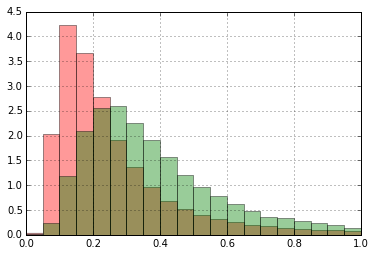

In [251]:
df = pd.DataFrame()
df['is_duplicate'] = train_df.head(100000).is_duplicate.values
df['mutual_info_match'] = mutual_info_match

df[df.is_duplicate == 0].mutual_info_match.abs().hist(normed=True, alpha=0.4, color='r', bins=np.arange(0, 1.05, 0.05))
df[df.is_duplicate == 1].mutual_info_match.abs().hist(normed=True, alpha=0.4, color='g', bins=np.arange(0, 1.05, 0.05))

In [452]:
%%time
normed_cos_match = []
for x in train_df.head(100000).iterrows():
    _, x = x
    v = cosine_similarity(
        (1 / np.array(model[x.question1])).reshape(1, -1),
        (1 / np.array(model[x.question2])).reshape(1, -1)
    )[0][0]

    normed_cos_match.append(v)

CPU times: user 48.6 s, sys: 0 ns, total: 48.6 s
Wall time: 48.5 s


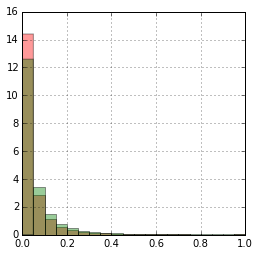

In [453]:
df = pd.DataFrame()
df['is_duplicate'] = train_df.head(100000).is_duplicate.values
df['normed_cos_match'] = normed_cos_match

df[df.is_duplicate == 0].normed_cos_match.abs().hist(normed=True, alpha=0.4, color='r', bins=np.arange(0, 1.05, 0.05))
df[df.is_duplicate == 1].normed_cos_match.abs().hist(normed=True, alpha=0.4, color='g', bins=np.arange(0, 1.05, 0.05))

In [454]:
print log_loss(train_df.head(100000).is_duplicate.values, fasttext_match)
print log_loss(train_df.head(100000).is_duplicate.values, mutual_info_match)
print log_loss(train_df.head(100000).is_duplicate.values, df.normed_cos_match)

1.23730231042
0.839536277491
6.40866615553


In [258]:
%%time
dtfidf = parallel_get_vector_based_scores(train_df.head(100000), is_train=True, batch=train_tfidf_batch_size, num_proc=NUM_PROC)

Current batch in main thread: 106530
CPU times: user 1.11 s, sys: 520 ms, total: 1.63 s
Wall time: 10.4 s


In [260]:
dtfidf['is_duplicate'] = train_df.head(100000).is_duplicate.values

In [263]:
dtfidf['fasttext_match'] = fasttext_match
dtfidf['mutual_info_match'] = mutual_info_match

In [262]:
print log_loss(dtfidf.is_duplicate, dtfidf.cv)
print log_loss(dtfidf.is_duplicate, dtfidf.wv)

0.618976672024
0.680376271505


In [ ]:
os_X_train, X_valid, os_y_train, y_valid = resample_and_split_train_val_data(dtfidf)

In [ ]:
bst = train_xgb(os_X_train, X_valid, os_y_train, y_valid)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
xgb.plot_importance(bst)
plt.show()

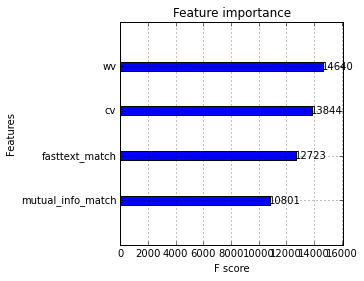

In [289]:
plt.rcParams['figure.figsize'] = (4.0, 4.0)
xgb.plot_importance(bst)
plt.show()

In [119]:
google_news_wv = load_google_news_w2v()

Current all-time max memory: 8616 MB


In [203]:
google_news_wv.most_similar('Visual')

[(u'visual', 0.5849171876907349),
 (u'Device_Interface_GDI', 0.525486946105957),
 (u'3D_Visualization', 0.5137205123901367),
 (u'Multisensory', 0.5115469694137573),
 (u'Gestural', 0.508009672164917),
 (u'Visualization', 0.5071419477462769),
 (u'Multi_Dimensional', 0.5053409934043884),
 (u'ToonIt', 0.5034863948822021),
 (u'InspireData', 0.503187358379364),
 (u'Visualizations', 0.5029371380805969)]